In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

## Домашнее задание

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р
4. Сделать выводы о том, какая модель справилась с задачей лучше других
5. *Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р

##Повторение кода с урока

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

Ссылка на google drive: https://drive.google.com/file/d/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

In [14]:
df = pd.read_csv('C:/Users/1/Downloads/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [15]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [17]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

## Обучение моделей

In [18]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier as rfc

In [34]:
def model_cv_score(model, rubl_test = 1400, rubl_early_treatment = 15000, rubl_late_treatment = 20000):

    print(f'\n{"*"*100}\nМодель: {model}\n')
  
    if model == 'LogisticRegression':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', LogisticRegression(random_state=42))
])

    elif model == 'XGBoost':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', xgb.XGBClassifier(random_state=42, n_estimators=100))
    ])  
    elif model == 'RandomForest':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', rfc(random_state=42))
])

  # запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'\nCV score is {cv_score}+-{cv_score_std}')

  # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    print(y_score)

    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'\nBest Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    roc_auc_score_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])
    roc_auc_score_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

    print(f"\nroc auc score train: {roc_auc_score_train}")
    print(f"roc auc score: {roc_auc_score_test}")

    cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    rubl_1 = (FN + TP) * rubl_late_treatment
    print('\nрасходы, если не делать тест и ждать симптомов:', rubl_1)  
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    print('расходы, если использовать МЛ:', rubl_ML)
    print('\nРасходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

    return cv_score, precision[ix], recall[ix], fscore[ix], roc_auc_score_test, TN, FN, TP, FP, cnf_matrix, y_score

In [35]:
result = dict()
for model in ['LogisticRegression', 'XGBoost', 'RandomForest']:
    result[model] = model_cv_score(model)


****************************************************************************************************
Модель: LogisticRegression


CV score is 0.7864573689384385+-0.004422021036885763
[0.21919629 0.24759828 0.40484498 ... 0.16941878 0.70519218 0.75098778]

Best Threshold=0.38693708911473756, F-Score=0.730, Precision=0.647, Recall=0.838

roc auc score train: 0.7870081561637485
roc auc score: 0.7840347790421852

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если использовать МЛ: 152974200

Расходы "решение не делать тесты - расходы с МL:" 20625800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1725800

****************************************************************************************************
Модель: XGBoost


CV score is 0.7971556462159913+-0.0025807632015828223
[0.1436425  0.19032502 0.35400474 ... 0.11356659 0

In [36]:
columns = ['cv_score', 'precision', 'recall', 'fscore', 'roc_auc_score_test', 'TN', 'FN', 'TP', 'FP']
index = [x for x in result.keys()]
result_df = pd.DataFrame([x[:9] for x in list(result.values())], index = index, columns = columns)
result_df

,cv_score,precision,recall,fscore,roc_auc_score_test,TN,FN,TP,FP
LogisticRegression,0.786457,0.647431,0.837558,0.730323,0.784035,4861,1411,7269,3959
XGBoost,0.797156,0.665248,0.828341,0.737890,0.797228,5202,1491,7189,3618
RandomForest,0.774380,0.642669,0.815553,0.718863,0.771037,4991,1663,7017,3829


Logistic Regression и Random Forest показывают сопоставимые результаты, в то время как XGBoost максиммизируя roc_auc избрала тактику всех пациентов записывать в здоровые. Попробуем для всех моделей оптимизировать порог "с точки зрения денег".

In [37]:
def business_threshold_calibrate(model, y_test, y_score,cnf_matrix,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    print(f'{"*"*100}\nДля модели {model}\n{"*"*100}\n')
    
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

****************************************************************************************************
Для модели LogisticRegression
****************************************************************************************************

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


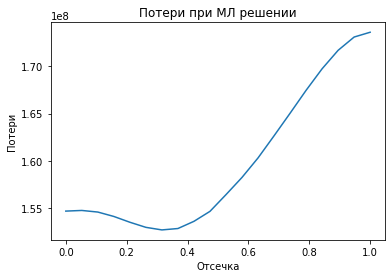

****************************************************************************************************
Для модели XGBoost
****************************************************************************************************

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152509800
Расходы "решение не делать тесты - расходы с МL:" 21090200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2190200


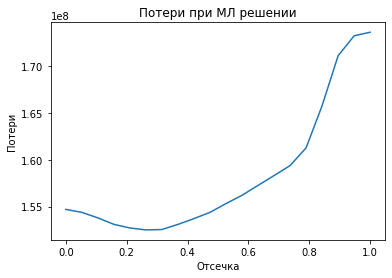

****************************************************************************************************
Для модели RandomForest
****************************************************************************************************

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 153132800
Расходы "решение не делать тесты - расходы с МL:" 20467200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1567200


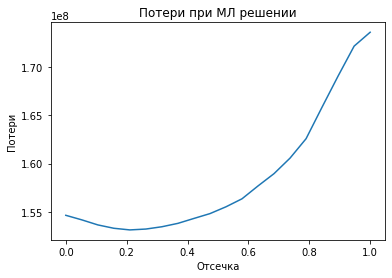

уровень порога по бизнес метрике 0.21052631578947367


In [38]:
for model in ['LogisticRegression', 'XGBoost', 'RandomForest']:
    busines_tr = business_threshold_calibrate(model, y_test, result[model][10], result[model][9], 
                                            rubl_test=1400, 
                                            rubl_early_treatment=15000, 
                                            rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)

В сравнении моделей по метрике "экономия денег для бизнеса" в лидерах бустинг над деревьями